## Import Libraries

Code reference from langchain academy course

In [2]:

from typing_extensions import TypedDict
from typing import Literal, Annotated

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from langchain_core.pydantic_v1 import BaseModel, validator, ValidationError
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph_sdk import get_client


import random
from operator import add
from dataclasses import dataclass
from IPython.display import display, Image
from dotenv import load_dotenv

load_dotenv(override=True)

True

# Intro

## Simple Graph

### State

State are structured data flowing between edges
Nodes are function that process and change state

In [8]:
class State(TypedDict):
    graph_state: str

In [4]:
def node1(state: State) -> str:
    print("=== Node 1 ===")
    return {"graph_state": state['graph_state'] + " I invest in"}

def node2(state: State) -> str:
    print("=== Node 2 ===")
    return {"graph_state": state['graph_state'] + " Stocks"}

def node3(state: State) -> str:
    print("=== Node 3 ===")
    return {"graph_state": state['graph_state'] + " Crypto"}

### Edge

Connecting state

In [5]:
# Conditional edge

def decide_investment(state: State) -> Literal["node2", "node3"]:
    print("=== Decision Node ===")
    
    input = state['graph_state']
    
    if random.random() < 0.5:
        return "node2"
    else:
        return "node3"

### Graph

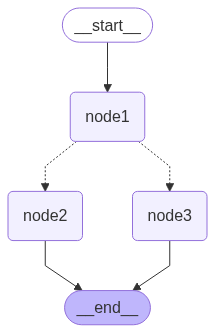

In [6]:
# Define the graph
builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Set entrypoint
# builder.set_entry_point("node1")

# Logic
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_investment)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"graph_state": "Hello, "})

=== Node 1 ===
=== Decision Node ===
=== Node 3 ===


{'graph_state': 'Hello,  I invest in Crypto'}

## Chain

### Messages

In [2]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model"),
    HumanMessage(content="Yes, that's right", name="Human"),
    AIMessage(content="Nice, what would you like to learn", name="Model"),
    HumanMessage(content="I would like to learn about financial statement", name="Human"),   
]

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement


### Chat Models

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [4]:
print(result.content)

Financial statements are crucial for understanding a company's financial health and making informed investment decisions. Here are the three primary financial statements you should be familiar with:

1. **Income Statement**: 
   - Also known as the profit and loss statement, it summarizes a company's revenues and expenses over a specific period, usually a quarter or a year.
   - Key components:
     - **Revenue**: The total income generated from sales of goods or services.
     - **Cost of Goods Sold (COGS)**: The direct costs attributable to the production of the goods sold by the company.
     - **Gross Profit**: Revenue minus COGS.
     - **Operating Expenses**: Costs required to run the business (such as selling, general, and administrative expenses).
     - **Net Income**: The profit after all expenses, taxes, and costs have been deducted from total revenue.

2. **Balance Sheet**: 
   - A snapshot of a company's financial position at a specific point in time, detailing assets, lia

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 541,
  'prompt_tokens': 54,
  'total_tokens': 595,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_51db84afab',
 'id': 'chatcmpl-C8ILNZYubVGo9zLQTmvZHVQ3NkHBf',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools

In [6]:
# Simple tool function
def multiply(a: int, b: int) -> int:
    return a * b

llm_tool = llm.bind_tools([multiply])

In [7]:
tool_call = llm_tool.invoke([HumanMessage(content="What is 50 x 12?")])

In [8]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'function': {'arguments': '{"a":50,"b":12}', 'name': 'multiply'},
  'type': 'function'}]

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 50, 'b': 12},
  'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'type': 'tool_call'}]

### MessagesState + MemorySaver checkpoint

In [ ]:
# Example add_messages with langgraph.graph.messages
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e278be8e-e4a8-48a5-bc93-48e12712f88d'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='8c3d28f0-73e1-402b-aff1-71dd2b38242e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='6882c5b8-e92a-4158-8039-1c48ec52d96c')]

In [12]:
class MessageState(MessagesState):
    pass

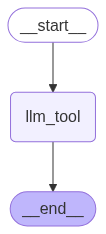

In [30]:
memory = MemorySaver()

def tooling_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

builder = StateGraph(MessageState)
builder.add_node("llm_tool", tooling_llm)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "BangDer"}}

In [32]:
message = graph.invoke({"messages": [HumanMessage(content="Hello")]}, config=config)

In [33]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?


In [34]:
message = graph.invoke({"messages": [HumanMessage(content="What is Jakarta most visited mall")]}, config=config)

In [35]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


In [46]:
state = graph.get_state(config=config)
for message in state.values['messages']:
    print(message.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


## Router

In [19]:
class MessageState(MessagesState):
    pass

def multiply(a: int, b: int) -> int:
    """Multiply a and b"""
    return a * b

llm = ChatOpenAI(model="gpt-4o-mini")
llm_tool = llm.bind_tools([multiply])

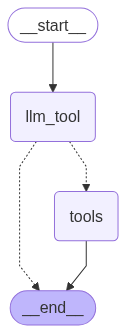

In [27]:
def tool_with_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

memory = MemorySaver()
builder = StateGraph(MessageState)
builder.add_node("llm_tool", tool_with_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
config = {"configurable": {"thread_id": "User2"}}

In [ ]:
messages = [HumanMessage(content="What is 50 x 12?")]
result = graph.invoke({"messages": messages}, config=config)

In [36]:
messages = [HumanMessage(content="Explain multiplier for 5 years kids")]
result = graph.invoke({"messages": messages}, config=config)

In [ ]:
for m in result['messages']:
    print(m.content) 

What is 50 x 12?

600
Explain multiplier for 5 years kids
A multiplier is like a magic number that helps us add the same number many times. 

Imagine you have 5 groups of 2 apples. Instead of counting each apple one by one, you can use a multiplier to make it faster. If you say "2 apples" and then "5 groups," you can find out how many apples there are in total by multiplying:

- So, 2 apples in each group × 5 groups = 10 apples.

This way, multiplying helps us find big numbers quickly without counting everything one by one!


## Agent

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_tools = llm.bind_tools(tools)

In [7]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")
def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}

The main idea of agent is we can node back to assistant node to process next tool if needed

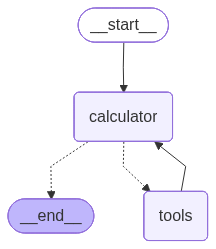

In [33]:
memory = MemorySaver()

builder = StateGraph(MessagesState)
builder.add_node("calculator", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "calculator")
builder.add_conditional_edges("calculator", tools_condition)
builder.add_edge("tools", "calculator")
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
config = {"configurable": {"thread_id": "User3"}}
messages = [HumanMessage(content="Add 10 and 50 then multiply with 5 then divide with 2")]
result = graph.invoke({"messages": messages}, config=config)

In [35]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

In [37]:
messages = [HumanMessage(content="Give me some fact based on that number")]
result = graph.invoke({"messages": messages}, config=config)

In [38]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

## Deployment

In [45]:
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistant = await client.assistants.search()
assistant

[{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-08-26T09:51:25.429747+00:00',
  'updated_at': '2025-08-26T09:51:25.429747+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'router',
  'created_at': '2025-08-26T09:51:25.402920+00:00',
  'updated_at': '2025-08-26T09:51:25.402920+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '28d99cab-ad6c-5342-aee5-400bd8dc9b8b',
  'graph_id': 'simple_graph',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'simple_graph',
  'created_at': '2025-08-26T09:51:24.294212+00:00',
  'updated_at': '2025-08-26T09:51:24.294212+00:00',
  'version': 1,
  'description': None}]

In [48]:
# We create a thread for tracking the state of our run
thread = await client.threads.create()

# Define the agent
agent = assistant[0]

In [56]:
input = {"messages": [HumanMessage(content="Add 5 and 50 then multiply by 3")]}

# Stream
async for chunk in client.runs.stream(
        thread['thread_id'],
        agent["assistant_id"],
        input=input,
        stream_mode="values",
    ):
    if chunk.data and chunk.event != "metadata":
        print(chunk.data['messages'][-1]['content'])

Add 5 and 50 then multiply by 3

165
The result of adding \(5\) and \(50\) is \(55\), and then multiplying that by \(3\) results in \(165\).


# State and Memory

## State Schema

### Typed Dict

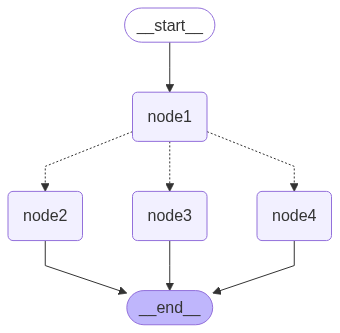

In [2]:
class TypedState(TypedDict):
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"]
    
def node1(state: TypedState):
    print("===Node 1===")
    return {"name": state['name']}

def node2(state: TypedState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: TypedState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: TypedState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: TypedState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(TypedState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"name": "Bangder"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Stock'}

### Dataclass

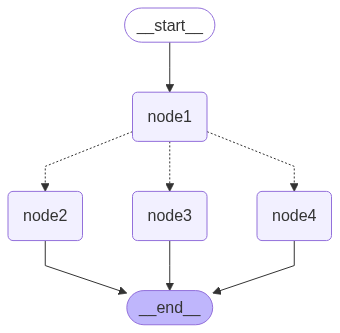

In [4]:
@dataclass
class ClassState:
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"] = "Stock"

def node1(state: ClassState):
    print("===Node 1===")
    return {"name": state.name}

def node2(state: ClassState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: ClassState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: ClassState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: ClassState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(ClassState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"name": "Bangder", "asset": "Any"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Stock'}

Dataclass provide type hint but they dont enforce type

### Pydantic

In [6]:
class PydanticState(BaseModel):
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"] = "Stock"
    
    @validator("asset")
    def validate_asset(cls, val):
       if val not in ["Stock", "Bonds", "Crypto"]:
           raise ValueError("Asset must be Stock, Bonds, or Crypto") 
       return val
   
try:
    state = PydanticState(name="Bangder", asset="Any")
except Exception as e:
    print("Error: ",e)

Error:  1 validation error for PydanticState
asset
  unexpected value; permitted: 'Stock', 'Bonds', 'Crypto' (type=value_error.const; given=Any; permitted=('Stock', 'Bonds', 'Crypto'))


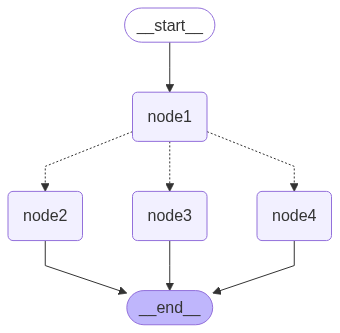

In [7]:
def node1(state: PydanticState):
    print("===Node 1===")
    return {"name": state.name}

def node2(state: PydanticState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: PydanticState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: PydanticState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: PydanticState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(PydanticState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"name": "Bangder", "asset": "Stock"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Bonds'}

## State Reducer

When a node branch into > 1 node and run in parallel, which means they run in the same step of graph, they both attempt to overwrite the state on the same step, this is why state reducer came

### Reducer

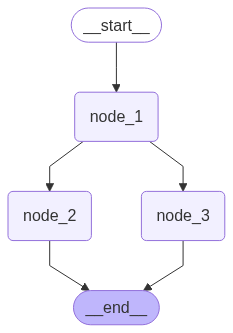

In [9]:
# Example Branching graph
class ReducerState(TypedDict):
    counter: Annotated[list[int], add]
    
def node_1(state: ReducerState):
    print("---Node 1---")
    return {"counter": [state['counter'][-1] + 1]}

def node_2(state: ReducerState):
    print("---Node 2---")
    return {"counter": [state['counter'][-1] + 2]}

def node_3(state: ReducerState):
    print("---Node 3---")
    return {"counter": [state['counter'][-1] + 3]}


builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"counter": [1]})

---Node 1---
---Node 2---
---Node 3---


{'counter': [1, 2, 4, 5]}

In [11]:
try:
    graph.invoke({"counter": None})
except Exception as e:
    print("Error: ",e)

Error:  can only concatenate list (not "NoneType") to list


Sometimes we need to input None to the node but it leave with error, so we have to make custom reducer instead of using add

### Custom Reducer

In [16]:
def reduce_list(old_state: list | None, new_state: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        old_state (list | None): The first list to combine, or None.
        new_state (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not old_state:
        old_state = []
    if not new_state:
        new_state = []
    return old_state + new_state

class DefaultState(TypedDict):
    counter: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    counter: Annotated[list[int], reduce_list]
    messages: Annotated[list[str], reduce_list]

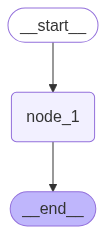

TypeError occurred: can only concatenate list (not "NoneType") to list


In [13]:
def node_1(state: DefaultState):
    print("---Node 1---")
    return {"counter": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"counter" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

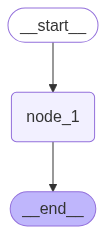

---Node 1---
{'counter': [2], 'messages': ['Bro', 'hi']}


In [22]:
# Build graph
def node_1(state: CustomReducerState):
    print("---Node 1---")
    return {"counter": [2], "messages": ["hi"]}

builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"counter" : None, "messages": ["Bro"]}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

### Messages

In [ ]:
# Both work the same things, add_messages works as reducer for messages
class CustomMessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    key_1: str
    key_2: str
    
class ExtendedMessagesState(MessagesState):
    key_1: str
    key_2: str


In [24]:
# add messages example
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on US Stock Market.", name="User")]

new_message = AIMessage(content="Sure, I can help with that. Which asset are you interested in?", name="Model")
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='2f3b1c40-f235-4cfd-bdd4-af2db7e16427'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='5107b1bd-6334-4fc7-99c6-608bea39f6a2'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='1c68186b-178f-4e65-84fb-791f2b2460a8')]

In [25]:
# We also can overwrite the message with ID
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on US Stock.", name="User", id="2")]

# New message to add
new_message = HumanMessage(content="I'm looking for information on Indo Stockk", name="User", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on Indo Stockk", additional_kwargs={}, response_metadata={}, name='User', id='2')]

In [ ]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model", id="1"),
    HumanMessage(content="Yes, that's right", name="Human", id="2"),
    AIMessage(content="Nice, what would you like to learn", name="Model", id="3"),
    HumanMessage(content="I would like to learn about financial statement", name="Human", id="4"),
]

# Delete 2 recent message
delete_messages = [RemoveMessage(id = message.id) for message in messages[:-2]]

for m in messages:
    print(m)
    
print("\n")
print("====" * 40)
print("\n")

deleted_message = add_messages(messages, delete_messages)
for d in deleted_message:
    print(d)

content='Do you invest in Stock Market?' additional_kwargs={} response_metadata={} name='Model' id='1'
content="Yes, that's right" additional_kwargs={} response_metadata={} name='Human' id='2'
content='Nice, what would you like to learn' additional_kwargs={} response_metadata={} name='Model' id='3'
content='I would like to learn about financial statement' additional_kwargs={} response_metadata={} name='Human' id='4'




content='Nice, what would you like to learn' additional_kwargs={} response_metadata={} name='Model' id='3'
content='I would like to learn about financial statement' additional_kwargs={} response_metadata={} name='Human' id='4'


## Multiple Schemas

**Private State & Input Output Schema**

Somehow our data only accessible for some nodes (not for client side nor output node), think about internal nodes that pass information that isn't required in input / output nodes

Sometimes we also want to use different schemas for input and output

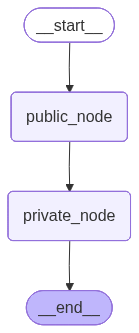

In [5]:
# Private State

class PublicState(TypedDict):
    public_num: int
    
class PrivateState(TypedDict):
    _private_num: int
    
def public_node(state: PublicState) -> PrivateState:
    return {"_private_num": state["public_num"] * 2}

def private_node(state: PrivateState) -> PublicState:
    return {"public_num": state["_private_num"] + 1}

builder = StateGraph(PublicState)
builder.add_node("public_node", public_node)
builder.add_node("private_node", private_node)

builder.add_edge(START, "public_node")
builder.add_edge("public_node", "private_node")
builder.add_edge("private_node", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"public_num": 2})

{'public_num': 5}

Only public data expose outside graph, private num don't expose outsite graph unless we return it to public

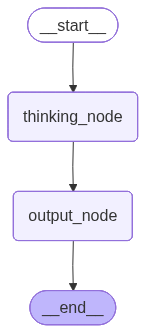

In [8]:
class InputState(TypedDict):
    question: str
    
class OutputState(TypedDict):
    answer: str
    
class InternalState(TypedDict):
    question: str
    answer: str
    notes: str
    
def thinking_node(state: InputState) -> InternalState:
    return {"question": state["question"], "answer": "Hi, may i help you?", "notes": "... thinking"}

def output_node(state: InternalState) -> OutputState:
    return {"answer": state["answer"]}

builder = StateGraph(InternalState, input_schema=InputState, output_schema=OutputState)
builder.add_node("thinking_node", thinking_node)
builder.add_node("output_node", output_node)

builder.add_edge(START, "thinking_node")
builder.add_edge("thinking_node", "output_node")
builder.add_edge("output_node", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"question": "Hi, how are you?"})

{'answer': 'Hi, may i help you?'}

Here we can customize input and output format and protect the internal state from being expose

## Trim and Filter Messages